In [33]:
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import theano.tensor as tt
from theano import shared
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
from pymc_utils import PyMCModel
from pymc_utils import hs_regression


In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [4]:
def plot_pairwise_corr(df_, ax=None, **heatmap_kwgs):
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 10))
    heatmap(df_.corr().iloc[1:,:-1],vmin=-1, vmax=1,
            mask=np.triu(np.ones([df_.shape[1]-1] * 2),k=1),
            ax=ax, **heatmap_kwgs,
            #annot=True, annot_kws={'fontsize': 10}, cmap=cmo.balance_r
           )
    ax.set_facecolor('k')
    return ax

def plot_fits_w_estimates(y_obs, ppc, ax=None, savename=False):
    """ Plot Fits with Uncertainty Estimates"""
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean =ppc.mean(axis=0)
    lik_hpd = pm.hpd(ppc)
    lik_hpd_05 = pm.hpd(ppc, alpha=0.5)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
    ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=100,
               color='steelblue', marker='d', zorder=2);
    ax.scatter(ix, lik_mean[iy], label='model mean', edgecolor='k', marker='^',
               s=100, color='orange', zorder=3)

    ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], color='gray', 
                   label='model output 50%CI', zorder=1,linestyle='-', lw=2, edgecolor='k');
    ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], color='k', alpha=0.75,
                   label='model output 95%CI', zorder=0, );
    ax.legend(loc='upper left');
    if savename:
        f = pl.gcf()
        f.savefig('./figJar/bayesNet/bNN_L1_nobias.pdf', format='pdf')
    return ax

def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    mae = mean_absolute_error(y_obs, ppc_mean)
    r2 = r2_score(y_obs, ppc_mean)
    
    scatter_lbl = f'$r^2$={r2:.2f}, mae={mae:.2f}'
    scatter_lbl = scatter_kwds.pop('label', scatter_lbl)
    ax.scatter(y_obs, ppc_mean, edgecolor='k', label=scatter_lbl, **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')
    ax.legend(loc='upper left')
    return ax

def uncertainty_plot_2(ppc_train, ppc_test, y_test_, y_train_, ax, band_color,
                      scatter_zorder=2, hpd_zorder=0, hpd_50_zorder=1):
    ix_ = np.argsort(y_train_)
    hpd_50 = pm.hpd(ppc_train[:, ix_], alpha=0.5)
    hpd = pm.hpd(ppc_train[:, ix_],)
    mean_ = ppc_train[:, ix_].mean(axis=0)
    mean_test_ = ppc_test.mean(axis=0)
    ax.scatter(mean_test_, y_test_, edgecolor='k', lw=2, zorder=scatter_zorder, color=band_color, s=50)
    ax.fill_betweenx(mean_, x1=hpd[:, 0], x2=hpd[:, 1], alpha=0.25, zorder=hpd_zorder, color=band_color)
    ax.fill_betweenx(mean_, x1=hpd_50[:, 0], x2=hpd_50[:, 1], alpha=0.25, color=band_color)

In [5]:
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_rs_6_FullSet_noInteractions.pkl')

In [6]:
dps = pd.read_pickle('./pickleJar/OperationalDataSets/df_rs_6_FullSet_MaxInteractions.pkl')

In [7]:
ds.head().T

,0,1,2,3,4
Biome,Westerlies,Polar,Polar,Polar,Trades
BiomCat,3,1,1,1,2
Province,"Mediterranean Sea, Black Sea Province",Antarctic Province,Austral Polar Province,Austral Polar Province,N. Atlantic Tropical Gyral Province (Trpg)
ProvCode,MEDI,ANTA,APLR,APLR,NATR
Coastal,0,0,0,0,0
ProvCat,42,22,25,25,33
sin_doy,-0.984474,0.790946,0.758306,0.369725,-0.997917
cos_doy,0.175531,0.611886,0.651899,0.929141,-0.0645084
sin_minofday,0.601815,-0.965926,-0.887011,-0.442289,0.134851
cos_minofday,-0.798636,-0.258819,-0.461749,-0.896873,-0.990866


In [8]:
feat_beg = 'sin_doy'
feat_end_ni = 'PC6_s'
feat_end_wi = 'PC5_s PC6_s'
X_s = ds.dropna().loc[:, feat_beg: feat_end_ni]
lbls_X_s = X_s.columns.tolist()

In [9]:
Xp_s = dps.dropna().loc[:, feat_beg: feat_end_wi]
lbls_Xp_s = Xp_s.columns.tolist()

In [10]:
y = ds.dropna().log10_chl

In [11]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)

Xp_s_train, Xp_s_test, yp_train, yp_test = train_test_split(Xp_s, y,
                                                                test_size=0.1,
                                                                random_state=42)

<u>Regularized Horseshoe, no interactions</u>

In [ ]:
pm.model_to_graphviz()

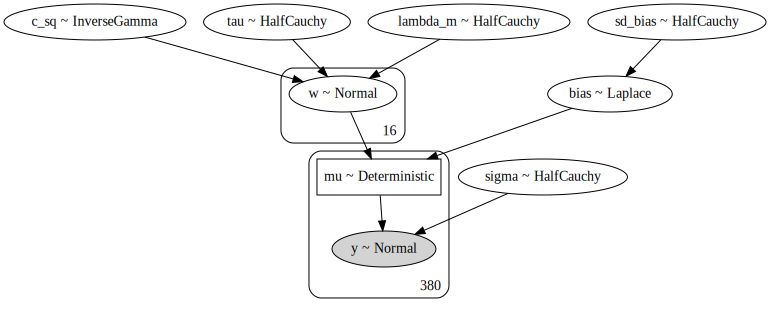

In [14]:
X_shared = shared(X_s_train.values)
m_reg_horseshoe = PyMCModel(hs_regression, X_shared, y_train,
                            regularized=True)

m_reg_horseshoe.show_model()

In [15]:
m_reg_horseshoe.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:14<00:00, 693.62draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


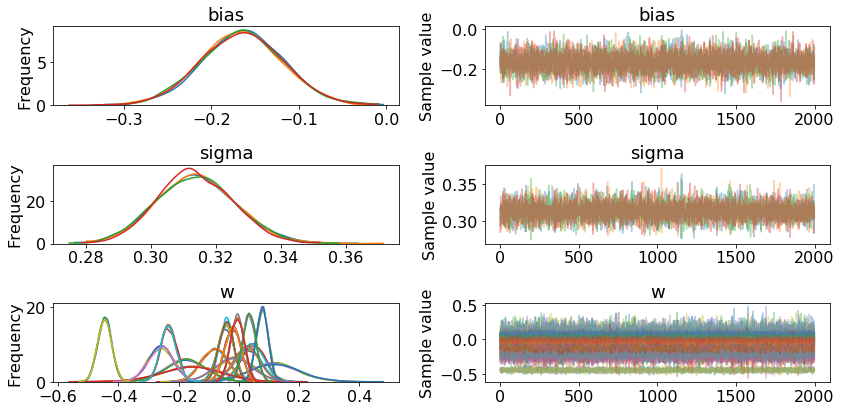

In [16]:
vars_ = ['bias', 'sigma', 'w',]
m_reg_horseshoe.evaluate_fit(show_feats=vars_);

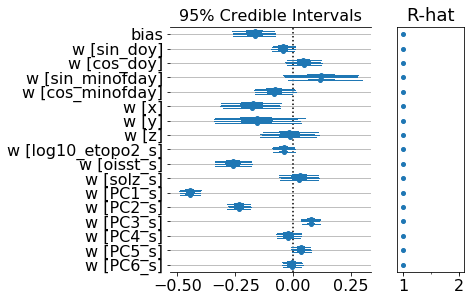

In [17]:
lbls = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()
lbls_list = ['bias'] + ['w [%s]' % lbl for lbl in lbls]
m_reg_horseshoe.show_forest(['bias', 'w'], feat_labels=lbls_list);

100%|██████████| 2000/2000 [00:01<00:00, 1318.61it/s]


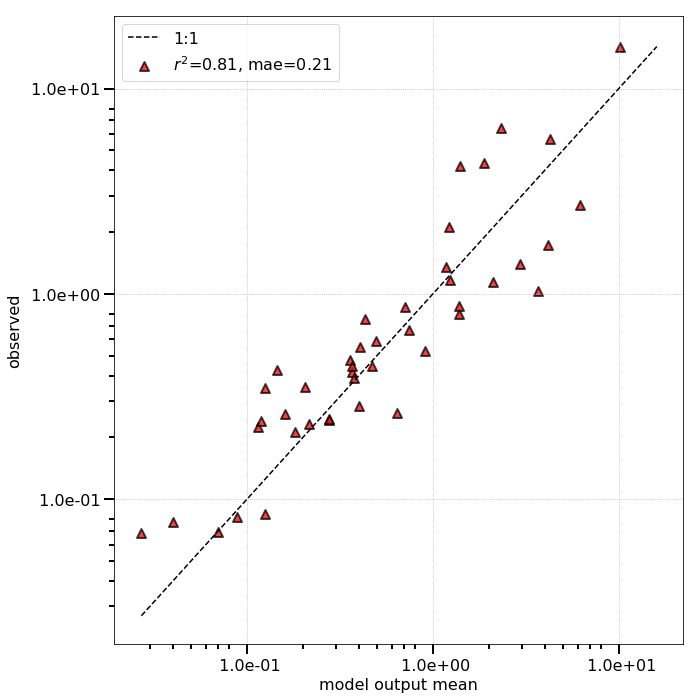

In [35]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_CHL = m_reg_horseshoe.predict(likelihood_name='y')
ax_test = plot_obs_against_ppc(y_test, ppc_test_CHL, plot_1_to_1=True, s=80,
                              color='red', alpha=0.75, linewidth=2, marker='^')
ax_test.set_yticks(np.log10(np.asarray([1e-1, 1e-0, 1e1])))
ax_test.set_xticks(np.log10(np.asarray([1e-1, 1e-0, 1e1])))
minor_ticks = np.concatenate((np.arange(3e-2, 9e-2, 1e-2), np.arange(2e-1, 9e-1, 1e-1),
                             np.arange(2e0, 9e0, 1e0)))
ax_test.set_yticks(np.log10(minor_ticks), minor=True)
ax_test.set_xticks(np.log10(minor_ticks), minor=True)
ax_test.tick_params(axis='both', which='minor', length=5, width=2)
ax_test.tick_params(axis='both', which='major', length=10, width=2)
#ax_test.tick_params(axis='x', which='both', length=0, width=0)
ax_test.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_test.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_test.grid(ls=':')
ax_test.set_xlabel('model output mean')
ax_test.set_ylabel('observed')
f = pl.gcf()
f.tight_layout()
f.savefig('./figJar/OO_2018/hs_reg_chl_test.pdf', dpi=300, format='pdf')

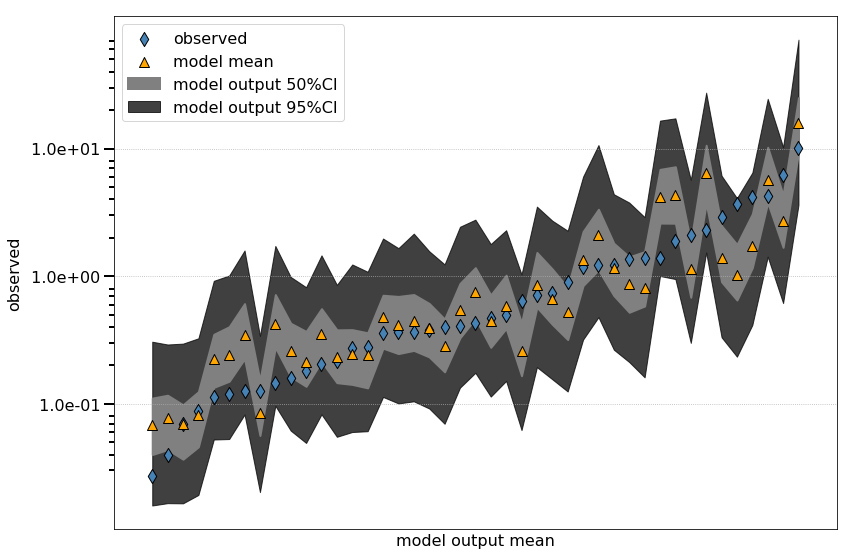

In [61]:
ax_unc = plot_fits_w_estimates(y_test, ppc_test_CHL)
ax_unc.set_yticks(np.log10(np.asarray([1e-1, 1e-0, 1e1])))
minor_ticks = np.concatenate((np.arange(3e-2, 9e-2, 1e-2), np.arange(2e-1, 9e-1, 1e-1),
                             np.arange(2e0, 9e0, 1e0), np.arange(2e1, 8e1, 1e1)))
ax_unc.set_yticks(np.log10(minor_ticks), minor=True)
ax_unc.tick_params(axis='y', which='minor', length=5, width=2)
ax_unc.tick_params(axis='y', which='major', length=10, width=2)
ax_unc.tick_params(axis='x', which='both', length=0, width=0)
ax_unc.set_xticks([])
ax_unc.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_unc.grid(ls=':')
ax_unc.set_xlabel('model output mean')
ax_unc.set_ylabel('observed')
f = pl.gcf()
f.tight_layout()
f.savefig('./figJar/OO_2018/hs_reg_chl_unc.pdf')

### Modeling with  Feature Interactions


In [38]:
X_shared_wi = shared(Xp_s_train.values)
mp_hs_wi = PyMCModel(hs_regression, X_shared_wi, yp_train, regularized=True)

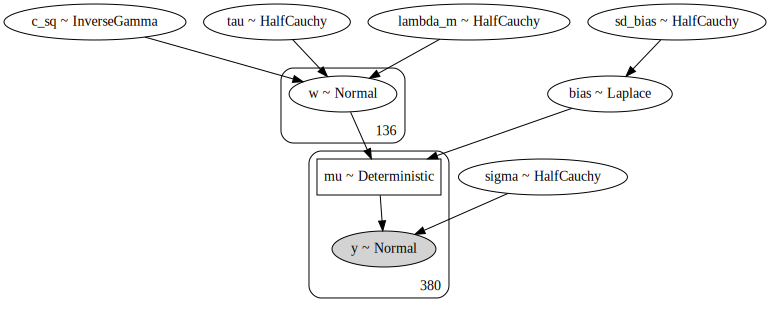

In [39]:
mp_hs_wi.show_model()

In [41]:
mp_hs_wi.fit(tune=2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]

 28%|██▊       | 1132/4000 [00:17<00:43, 65.85it/s]


 61%|██████    | 2438/4000 [00:34<00:21, 71.02it/s]


 94%|█████████▍| 3763/4000 [00:50<00:03, 73.89it/s]


100%|██████████| 4000/4000 [00:53<00:00, 74.65it/s]Only one chain was sampled, this makes it impossible to run some convergence checks


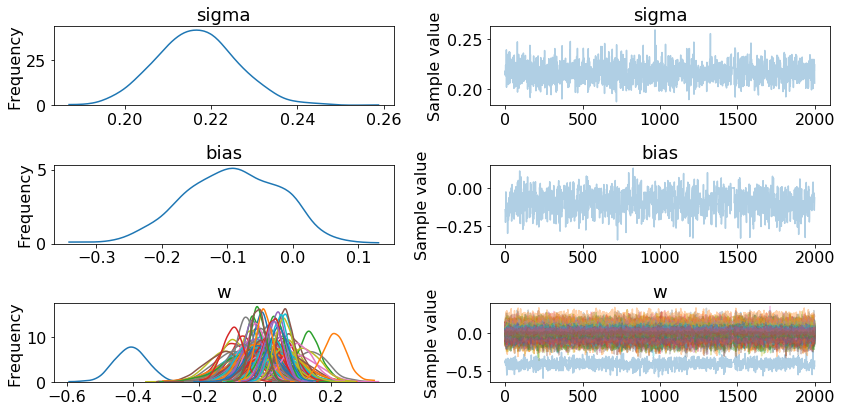

In [43]:
vars_ =['sigma', 'bias', 'w']
mp_hs_wi.evaluate_fit(vars_);

In [48]:
ppc_test_hs_wi.shape

(2000, 380)

In [ ]:
X


100%|██████████| 2000/2000 [00:01<00:00, 1259.86it/s]

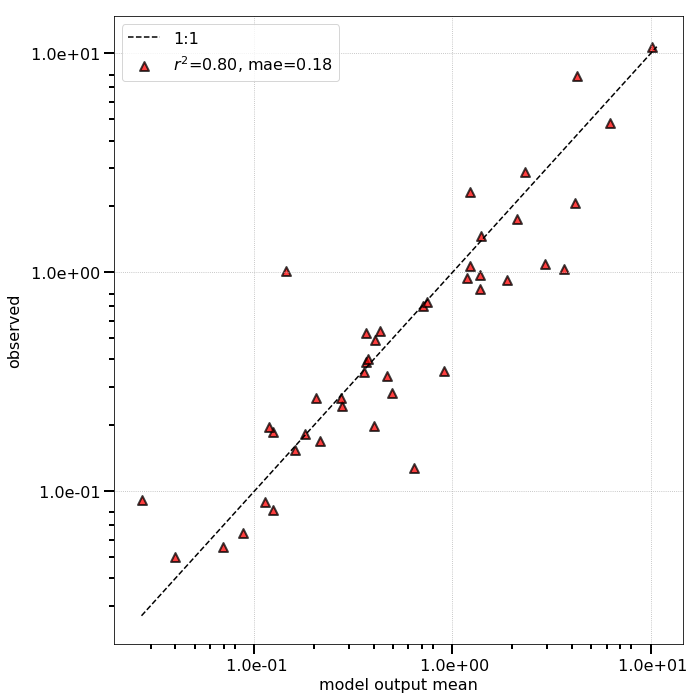

In [53]:
# Check Fit on Test Data
X_shared_wi.set_value(Xp_s_test.values)
ppc_test_hs_wi = mp_hs_wi.predict(likelihood_name='y')
ax_test = plot_obs_against_ppc(yp_test, ppc_test_hs_wi, plot_1_to_1=True, s=80,
                              color='red', alpha=0.75, linewidth=2, marker='^')
ax_test.set_yticks(np.log10(np.asarray([1e-1, 1e-0, 1e1])))
ax_test.set_xticks(np.log10(np.asarray([1e-1, 1e-0, 1e1])))
minor_ticks = np.concatenate((np.arange(3e-2, 9e-2, 1e-2), np.arange(2e-1, 9e-1, 1e-1),
                             np.arange(2e0, 9e0, 1e0)))
ax_test.set_yticks(np.log10(minor_ticks), minor=True)
ax_test.set_xticks(np.log10(minor_ticks), minor=True)
ax_test.tick_params(axis='both', which='minor', length=5, width=2)
ax_test.tick_params(axis='both', which='major', length=10, width=2)
#ax_test.tick_params(axis='x', which='both', length=0, width=0)
ax_test.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_test.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_test.grid(ls=':')
ax_test.set_xlabel('model output mean')
ax_test.set_ylabel('observed')
f = pl.gcf()
f.tight_layout()
f.savefig('./figJar/OO_2018/hs_reg_wi_chl_test.pdf', dpi=300, format='pdf')

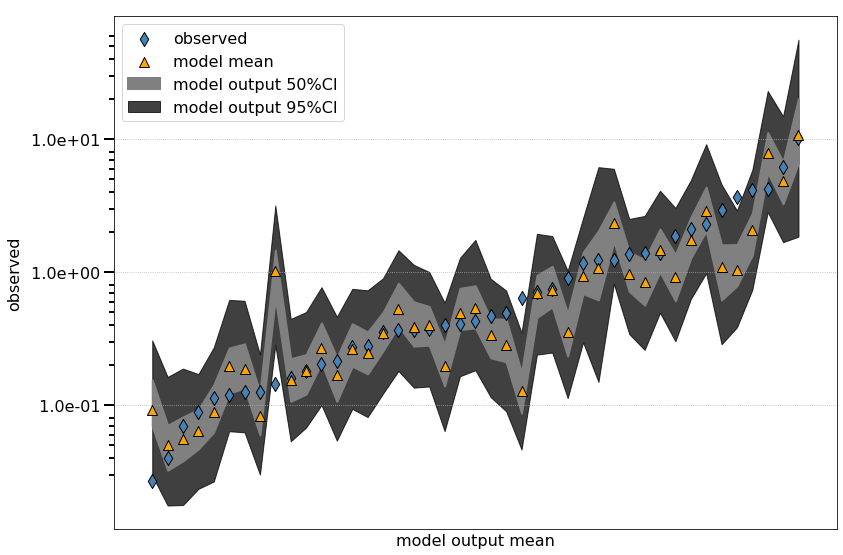

In [62]:
ax_unc = plot_fits_w_estimates(yp_test, ppc_test_hs_wi)
ax_unc.set_yticks(np.log10(np.asarray([1e-1, 1e-0, 1e1,])))
minor_ticks = np.concatenate((np.arange(3e-2, 9e-2, 1e-2), np.arange(2e-1, 9e-1, 1e-1),
                             np.arange(2e0, 9e0, 1e0), np.arange(2e1, 7e1, 1e1)))
ax_unc.set_yticks(np.log10(minor_ticks), minor=True)
ax_unc.tick_params(axis='y', which='minor', length=5, width=2)
ax_unc.tick_params(axis='y', which='major', length=10, width=2)
ax_unc.tick_params(axis='x', which='both', length=0, width=0)
ax_unc.set_xticks([])
ax_unc.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_unc.grid(ls=':')
ax_unc.set_xlabel('model output mean')
ax_unc.set_ylabel('observed')
f = pl.gcf()
f.tight_layout()
f.savefig('./figJar/OO_2018/hs_reg_wi_unc.pdf')

In [90]:
mod_dict = {m_lasso_.model: m_lasso_.trace_,
            m_reg_horseshoe.model: m_reg_horseshoe.trace_,
            mlasso_sub.model: mlasso_sub.trace_,
            mp_lasso.model: mp_lasso.trace_,
            mp_lasso_sub.model: mp_lasso_sub.trace_,
           }
pm.compare(mod_dict)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
lasso_regr_w_sub_inter.,-12.49,66.2,0,0.74,36.1,0,1
lasso_w_interactions,159.77,105.66,172.26,0.24,38.36,52.03,1
lasso_regr_sub,178.27,13.62,190.76,0.02,32.63,45.96,1
reg_horseshoe,215.92,18.79,228.41,0,32.23,48.38,1
lasso_regr,216.86,18.56,229.35,0,32.21,48.39,1


In [91]:
pm.compare(mod_dict, ic='LOO')

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
lasso_regr_w_sub_inter.,8.63,76.76,0,0.72,38.75,0,1
lasso_regr_sub,178.36,13.67,169.73,0.04,32.64,47.65,0
reg_horseshoe,216.2,18.92,207.57,0,32.27,50.61,0
lasso_regr,217.15,18.71,208.53,0,32.25,50.63,1
lasso_w_interactions,228.8,140.18,220.17,0.23,50.15,63.38,1


In [92]:
models_dict = {m_lasso_.model.name: m_lasso_,
            m_reg_horseshoe.model.name: m_reg_horseshoe,
            mlasso_sub.model.name: mlasso_sub,
            mp_lasso.model.name: mp_lasso,
            mp_lasso_sub.model.name: mp_lasso_sub,
           }
with open('./pickleJar/Models/pooled_models_from_train_test_split.pkl', 'wb') as f:
    pickle.dump(models_dict, f, protocol=pickle.HIGHEST_PROTOCOL)